<h1 style="color: white;">CS 109A Final Project Milestone 4</h1>


_The COVID-19 pandemic has significantly reshaped the American workforce, introducing widespread remote working possibilities. This shift has the potential to redistribute population and economic activity across the United States, as workers gain the flexibility to move without job constraints. Such movements are influenced not only by remote work opportunities but also by factors like housing market trends, demographic diversity including racial composition, education facilities, and varying levels of COVID-19 preparedness in different regions. This trend and its implications have been the subject of recent research, with findings accessible at https://www.nytimes.com/interactive/2021/04/19/upshot/how-the-pandemic-did-and-didnt-change-moves.html. These insights have motivated our project, aimed at predicting migration patterns within the USA. Our analysis focuses on county-level data and utilizes a combination of public datasets to understand and model these migration dynamics_

The primary data sources used are ACS 5 year estimates - in particular demographic and social indicators for 2019 and 2021. An additional new dataset used was COVID-19 related data compiled by Kaggle (https://www.kaggle.com/code/johnjdavisiv/us-counties-weather-health-hospitals-covid19-data) which contains a wealth of information from data sources below:

1. New York Times county-level COVID19 case and fatality data (part of UNCOVER data)
2. Documentation with notes on geographic exceptions (NYC and Kansas City) is at the NYT Github
3. 2016 CDC Social Vulnerability Data (part of UNCOVER data)
4. 2020 Community Health Rankings Data (part of UNCOVER data)
5. NOAA Global Surface Summary of the Day (GSOD) weather data for 2020
6. Each county is paired with the nearest weather station. Most stations are within 50 km of the county center, and virtually all are within 100 km of the county center
7. Kaiser Family Foundation Data on state-level stay-at-home orders

In [1]:
# RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2021-CS109A/master/"
    "themes/static/css/cs109.css"
).text
HTML(styles)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from functools import reduce
import os
import warnings
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV

In [3]:
# set directory
#os.chdir('/Users/shreyad/Library/CloudStorage/OneDrive-HarvardUniversity/DS Final Project/1. Data')
os.chdir('/Users/seharnoor/Library/CloudStorage/OneDrive-HarvardUniversity/Fall 2023/CS 109A/DS Final Project/1. Data')
#print(os.getcwd())

# ignore warnings for a clean file
warnings.filterwarnings('ignore')

<h2 style="color: black;">Data Pipeline</h2>

<h3 style="color:#B9063F;">Dataset 1: ACS Social Data</h3>

In [4]:
# load datasets
ACS_social_2019 = pd.read_csv("3. US Census/ACS_5Y/metadata etc/Social/ACSDP5Y2019.DP02_2023-11-22T130635/ACSDP5Y2019.DP02-Data.csv", low_memory=False)
ACS_social_2021 = pd.read_csv("3. US Census/ACS_5Y/metadata etc/Social/ACSDP5Y2021.DP02_2023-11-22T130630/ACSDP5Y2021.DP02-Data.csv", low_memory=False)

In [5]:
# Add suffixes to columns
ACS_social_2019['year'] = 2019
ACS_social_2021['year'] = 2021

# append all data together
appended_acs_social_data = pd.concat([ACS_social_2019, ACS_social_2021])

In [6]:
appended_acs_social_data.head()

,GEO_ID,NAME,DP02_0001E,DP02_0001M,DP02_0002E,DP02_0002M,DP02_0003E,DP02_0003M,DP02_0004E,DP02_0004M,...,DP02_0152PM,DP02_0153PE,DP02_0153PM,Unnamed: 614,year,DP02_0154E,DP02_0154M,DP02_0154PE,DP02_0154PM,Unnamed: 618
0,Geography,Geographic Area Name,Estimate!!HOUSEHOLDS BY TYPE!!Total households,Margin of Error!!HOUSEHOLDS BY TYPE!!Total hou...,Estimate!!HOUSEHOLDS BY TYPE!!Total households...,Margin of Error!!HOUSEHOLDS BY TYPE!!Total hou...,Estimate!!HOUSEHOLDS BY TYPE!!Total households...,Margin of Error!!HOUSEHOLDS BY TYPE!!Total hou...,Estimate!!HOUSEHOLDS BY TYPE!!Total households...,Margin of Error!!HOUSEHOLDS BY TYPE!!Total hou...,...,Percent Margin of Error!!COMPUTERS AND INTERNE...,Percent!!COMPUTERS AND INTERNET USE!!Total hou...,Percent Margin of Error!!COMPUTERS AND INTERNE...,NaN,2019,NaN,NaN,NaN,NaN,NaN
1,0500000US01001,"Autauga County, Alabama",21397,325,11609,546,4878,436,738,200,...,1.4,80.6,1.9,NaN,2019,NaN,NaN,NaN,NaN,NaN
2,0500000US01003,"Baldwin County, Alabama",80930,1127,42886,1114,14352,805,3310,509,...,1.0,81.8,1.2,NaN,2019,NaN,NaN,NaN,NaN,NaN
3,0500000US01005,"Barbour County, Alabama",9345,313,3958,230,1204,209,333,137,...,2.3,60.5,2.6,NaN,2019,NaN,NaN,NaN,NaN,NaN
4,0500000US01007,"Bibb County, Alabama",6891,333,3493,354,1263,232,152,92,...,3.5,69.2,4.3,NaN,2019,NaN,NaN,NaN,NaN,NaN


In [7]:
# Get the headers from the second row, which contains the descriptive text.
descriptive_headers_social = appended_acs_social_data.iloc[0]
header_dict_social = descriptive_headers_social.to_dict()

# Filter out the columns that contain 'Estimate!!' and also include 'Geography' and 'Geographic Area Name'
estimate_columns_social = [col for col, desc in header_dict_social.items() if "Estimate!!" in str(desc) and not desc.startswith("Annotation of Estimate!!")]

# Include 'GEO_ID' and 'NAME' columns which might not contain 'Estimate!!'
estimate_columns_social.extend(['GEO_ID', 'NAME', 'year'])

In [8]:
filtered_social_ACS = appended_acs_social_data[estimate_columns_social]
filtered_social_ACS.head()

,DP02_0001E,DP02_0002E,DP02_0003E,DP02_0004E,DP02_0005E,DP02_0006E,DP02_0007E,DP02_0008E,DP02_0009E,DP02_0010E,...,DP02_0147E,DP02_0148E,DP02_0149E,DP02_0150E,DP02_0151E,DP02_0152E,DP02_0153E,GEO_ID,NAME,year
0,Estimate!!HOUSEHOLDS BY TYPE!!Total households,Estimate!!HOUSEHOLDS BY TYPE!!Total households...,Estimate!!HOUSEHOLDS BY TYPE!!Total households...,Estimate!!HOUSEHOLDS BY TYPE!!Total households...,Estimate!!HOUSEHOLDS BY TYPE!!Total households...,Estimate!!HOUSEHOLDS BY TYPE!!Total households...,Estimate!!HOUSEHOLDS BY TYPE!!Total households...,Estimate!!HOUSEHOLDS BY TYPE!!Total households...,Estimate!!HOUSEHOLDS BY TYPE!!Total households...,Estimate!!HOUSEHOLDS BY TYPE!!Total households...,...,Estimate!!ANCESTRY!!Total population!!Swiss,Estimate!!ANCESTRY!!Total population!!Ukrainian,Estimate!!ANCESTRY!!Total population!!Welsh,Estimate!!ANCESTRY!!Total population!!West Ind...,Estimate!!COMPUTERS AND INTERNET USE!!Total ho...,Estimate!!COMPUTERS AND INTERNET USE!!Total ho...,Estimate!!COMPUTERS AND INTERNET USE!!Total ho...,Geography,Geographic Area Name,2019
1,21397,11609,4878,738,148,3253,281,2501,666,5797,...,40,0,389,28,21397,19096,17239,0500000US01001,"Autauga County, Alabama",2019
2,80930,42886,14352,3310,865,12551,837,9847,3363,22183,...,359,133,976,657,80930,73588,66214,0500000US01003,"Baldwin County, Alabama",2019
3,9345,3958,1204,333,196,1670,97,1288,347,3384,...,0,13,52,52,9345,7213,5656,0500000US01005,"Barbour County, Alabama",2019
4,6891,3493,1263,152,54,1424,114,942,242,1822,...,0,0,73,0,6891,5382,4769,0500000US01007,"Bibb County, Alabama",2019


In [9]:
# Extract the last five characters of 'GEO_ID', ensuring it's a string and preserving leading zeros
filtered_social_ACS['fips_id'] = filtered_social_ACS['GEO_ID'].astype(str).apply(lambda x: x[-5:].zfill(5))

# Reorder columns to move 'FIPS_ID' to the first position
cols_social = ['fips_id'] + [col for col in filtered_social_ACS.columns if col != 'fips_id']
filtered_social_ACS = filtered_social_ACS[cols_social]

In [10]:
# move, geo_id, name, year to the front of the dataset
cols_to_move = ['GEO_ID', 'NAME', 'year']
other_cols_social = [col for col in filtered_social_ACS.columns if col not in cols_to_move]
new_order = cols_to_move + other_cols_social
filtered_social_ACS = filtered_social_ACS[new_order]

In [11]:
# Select the first two rows of the dataset
first_two_rows_social = filtered_social_ACS.iloc[:1]

# Transpose the data so I can add variable names in csv
transposed_first_data_social = first_two_rows_social.transpose()
transposed_first_data_social.to_csv('3. US Census/transposed_social_acs.csv', index=True)

In [12]:
rename_dict_social = {
    "DP02_0001E": "total_hh",
    "DP02_0002E": "total_married_family",
    "DP02_0003E": "total_married_child_under_18",
    "DP02_0004E": "total_cohabitating",
    "DP02_0005E": "total_cohab_child_under_18",
    "DP02_0006E": "total_male_householder",
    "DP02_0007E": "total_male_householder_child",
    "DP02_0008E": "total_male_householder_alone",
    "DP02_0009E": "total_male_householder_65_plus",
    "DP02_0010E": "total_female_householder",
    "DP02_0011E": "total_female_householder_child",
    "DP02_0012E": "total_female_householder_alone",
    "DP02_0013E": "total_female_householder_65_plus",
    "DP02_0014E": "total_one_more_under_18",
    "DP02_0015E": "total_one_more_over_65",
    "DP02_0016E": "avg_hh_size",
    "DP02_0017E": "avg_family_size",
    "DP02_0018E": "pop_hhs",
    "DP02_0019E": "pop_householder",
    "DP02_0020E": "pop_spouse",
    "DP02_0021E": "pop_unmarried_partner",
    "DP02_0022E": "pop_child",
    "DP02_0023E": "pop_other_relatives",
    "DP02_0024E": "pop_non_relatives",
    "DP02_0025E": "total_male_15_above",
    "DP02_0026E": "total_male_never_married",
    "DP02_0027E": "total_male_married",
    "DP02_0028E": "total_male_separated",
    "DP02_0029E": "total_male_widowed",
    "DP02_0030E": "total_male_divorced",
    "DP02_0031E": "total_female_15_above",
    "DP02_0032E": "total_female_never_married",
    "DP02_0033E": "total_female_married",
    "DP02_0034E": "total_female_separated",
    "DP02_0035E": "total_female_widowed",
    "DP02_0036E": "total_female_divorced",
    "DP02_0053E": "pop_3_above_enrolled_school",
    "DP02_0054E": "pop_3_above_preschool",
    "DP02_0055E": "pop_3_above_kindergarten",
    "DP02_0056E": "pop_3_above_elementary",
    "DP02_0057E": "pop_3_above_high_school",
    "DP02_0058E": "pop_3_above_high_college",
    "DP02_0059E": "pop_25_above",
    "DP02_0060E": "pop_25_above_less_9_grade",
    "DP02_0061E": "pop_25_above_9_12_grade",
    "DP02_0062E": "pop_25_above_high_school_grad",
    "DP02_0063E": "pop_25_above_some_college_no_deg",
    "DP02_0064E": "pop_25_above_associate_degree",
    "DP02_0065E": "pop_25_above_bachelor_degree",
    "DP02_0066E": "pop_25_above_grad_or_prof_degree",
    "DP02_0067E": "pop_25_above_high_school_grad_higher",
    "DP02_0068E": "pop_25_above_bach_degree_higher",
    "DP02_0087E": "total_pop_v3",
    "DP02_0088E": "total_pop_native",
    "DP02_0089E": "total_pop_born_us",
    "DP02_0090E": "total_pop_born_us_state_residence",
    "DP02_0091E": "total_pop_born_us_diff_state",
    "DP02_0092E": "total_pop_born_abroad_american",
    "DP02_0093E": "total_pop_foreign_born",
    "DP02_0094E": "foreign_born_pop",
    "DP02_0095E": "foreign_born_pop_naturalized",
    "DP02_0096E": "foreign_born_pop_not_citizen",
    "DP02_0097E": "pop_born_outside_us_native",
    "DP02_0104E": "foreign_born_pop_v2",
    "DP02_0105E": "foreign_born_pop_europe",
    "DP02_0106E": "foreign_born_pop_asia",
    "DP02_0107E": "foreign_born_pop_africa",
    "DP02_0108E": "foreign_born_pop_oceania",
    "DP02_0109E": "foreign_born_pop_latin_a",
    "DP02_0110E": "foreign_born_pop_nothern_a",
    "DP02_0111E": "pop_5_and_above",
    "DP02_0112E": "pop_5_above_english",
    "DP02_0113E": "pop_5_above_lang_other_english",
    "DP02_0114E": "pop_5_above_lang_english_not_well",
    "DP02_0115E": "pop_5_above_spanish",
    "DP02_0116E": "pop_5_above_lang_spanish_english_not_well",
    "DP02_0117E": "pop_5_above_indo_euro_lang",
    "DP02_0118E": "pop_5_above_lang_indo_english_not_well",
    "DP02_0119E": "pop_5_above_asia_pacif_lang",
    "DP02_0120E": "pop_5_above_lang_asia_english_not_well",
    "DP02_0121E": "pop_5_above_other_lang",
    "DP02_0122E": "pop_5_above_other_lang_english_not_well",
    "DP02_0151E": "total_hh_v3",
    "DP02_0152E": "total_hh_with_comp",
    "DP02_0153E": "total_hh_with_internet"
}

In [13]:
filtered_social_ACS_v2 = filtered_social_ACS.rename(columns=rename_dict_social)

In [14]:
# drop the first row of the dataset
filtered_social_ACS_v2 = filtered_social_ACS_v2.drop(filtered_social_ACS_v2.index[0])

# drop columns that are not needed

variables_to_drop = [
    "DP02_0001E", "DP02_0002E", "DP02_0003E", "DP02_0004E", "DP02_0005E",
    "DP02_0006E", "DP02_0007E", "DP02_0008E", "DP02_0009E", "DP02_0010E",
    "DP02_0011E", "DP02_0012E", "DP02_0013E", "DP02_0014E", "DP02_0015E",
    "DP02_0016E", "DP02_0017E", "DP02_0018E", "DP02_0019E", "DP02_0020E",
    "DP02_0021E", "DP02_0022E", "DP02_0023E", "DP02_0024E", "DP02_0025E",
    "DP02_0026E", "DP02_0027E", "DP02_0028E", "DP02_0029E", "DP02_0030E",
    "DP02_0031E", "DP02_0032E", "DP02_0033E", "DP02_0034E", "DP02_0035E",
    "DP02_0036E", "DP02_0053E", "DP02_0054E", "DP02_0055E", "DP02_0056E",
    "DP02_0057E", "DP02_0058E", "DP02_0059E", "DP02_0060E", "DP02_0061E",
    "DP02_0062E", "DP02_0063E", "DP02_0064E", "DP02_0065E", "DP02_0066E",
    "DP02_0067E", "DP02_0068E", "DP02_0087E", "DP02_0088E", "DP02_0089E",
    "DP02_0090E", "DP02_0091E", "DP02_0092E", "DP02_0093E", "DP02_0094E",
    "DP02_0095E", "DP02_0096E", "DP02_0097E", "DP02_0104E", "DP02_0105E",
    "DP02_0106E", "DP02_0107E", "DP02_0108E", "DP02_0109E", "DP02_0110E",
    "DP02_0111E", "DP02_0112E", "DP02_0113E", "DP02_0114E", "DP02_0115E",
    "DP02_0116E", "DP02_0117E", "DP02_0118E", "DP02_0119E", "DP02_0120E",
    "DP02_0121E", "DP02_0122E", "DP02_0151E", "DP02_0152E", "DP02_0153E",
    "DP02_0144E", "DP02_0145E", "DP02_0146E", "DP02_0147E", "DP02_0148E", 
    "DP02_0149E", "DP02_0150E", "DP02_0123E", "DP02_0124E", "DP02_0125E",
    "DP02_0126E", "DP02_0127E", "DP02_0128E", "DP02_0129E", "DP02_0130E", 
    "DP02_0131E", "DP02_0132E", "DP02_0133E", "DP02_0134E", "DP02_0135E",
    "DP02_0136E", "DP02_0137E", "DP02_0138E", "DP02_0139E", "DP02_0140E",
    "DP02_0141E", "DP02_0142E", "DP02_0143E"]

filtered_social_ACS_v2 = filtered_social_ACS_v2.drop(columns=variables_to_drop, errors='ignore')

In [15]:
filtered_social_ACS_v2 = filtered_social_ACS_v2.replace('N', np.nan)

In [16]:
filtered_social_ACS_v2.head()

,GEO_ID,NAME,year,fips_id,total_hh,total_married_family,total_married_child_under_18,total_cohabitating,total_cohab_child_under_18,total_male_householder,...,pop_5_above_lang_spanish_english_not_well,pop_5_above_indo_euro_lang,pop_5_above_lang_indo_english_not_well,pop_5_above_asia_pacif_lang,pop_5_above_lang_asia_english_not_well,pop_5_above_other_lang,pop_5_above_other_lang_english_not_well,total_hh_v3,total_hh_with_comp,total_hh_with_internet
1,0500000US01001,"Autauga County, Alabama",2019,01001,21397,11609,4878,738,148,3253,...,317,110,11,649,287,141,131,21397,19096,17239
2,0500000US01003,"Baldwin County, Alabama",2019,01003,80930,42886,14352,3310,865,12551,...,2583,2589,532,848,430,72,0,80930,73588,66214
3,0500000US01005,"Barbour County, Alabama",2019,01005,9345,3958,1204,333,196,1670,...,504,162,69,126,42,43,12,9345,7213,5656
4,0500000US01007,"Bibb County, Alabama",2019,01007,6891,3493,1263,152,54,1424,...,275,55,0,0,0,0,0,6891,5382,4769
5,0500000US01009,"Blount County, Alabama",2019,01009,20847,11909,4269,454,157,3716,...,1796,228,16,48,14,47,10,20847,16877,15220


In [17]:
distinct_count_by_year_social = filtered_social_ACS_v2.groupby('year')['fips_id'].nunique()
distinct_count_by_year_social

year
2019    3220
2021    3221
Name: fips_id, dtype: int64

<h3 style="color:#B9063F;">Dataset 2: ACS Demographic Data</h3>

In [18]:
# Load files with low_memory=False
ACS_2019 = pd.read_csv("3. US Census/ACS_5Y/metadata etc/Demographic/ACSDP5Y2019.DP05_2023-11-22T130645/ACSDP5Y2019.DP05-Data.csv", low_memory=False)
ACS_2021 = pd.read_csv("3. US Census/ACS_5Y/metadata etc/Demographic/ACSDP5Y2021.DP05_2023-11-22T130641/ACSDP5Y2021.DP05-Data.csv", low_memory=False)

In [19]:
# Add suffixes to columns
ACS_2019['year'] = 2019
ACS_2021['year'] = 2021

# append all data together
appended_acs_demographic_data = pd.concat([ACS_2019, ACS_2021])

In [20]:
appended_acs_demographic_data.head()

,GEO_ID,NAME,DP05_0001E,DP05_0001M,DP05_0002E,DP05_0002M,DP05_0003E,DP05_0003M,DP05_0004E,DP05_0004M,...,DP05_0086PE,DP05_0086PM,DP05_0087PE,DP05_0087PM,DP05_0088PE,DP05_0088PM,DP05_0089PE,DP05_0089PM,Unnamed: 358,year
0,Geography,Geographic Area Name,Estimate!!SEX AND AGE!!Total population,Margin of Error!!SEX AND AGE!!Total population,Estimate!!SEX AND AGE!!Total population!!Male,Margin of Error!!SEX AND AGE!!Total population...,Estimate!!SEX AND AGE!!Total population!!Female,Margin of Error!!SEX AND AGE!!Total population...,Estimate!!SEX AND AGE!!Total population!!Sex r...,Margin of Error!!SEX AND AGE!!Total population...,...,Percent!!Total housing units,Percent Margin of Error!!Total housing units,"Percent!!CITIZEN, VOTING AGE POPULATION!!Citiz...","Percent Margin of Error!!CITIZEN, VOTING AGE P...","Percent!!CITIZEN, VOTING AGE POPULATION!!Citiz...","Percent Margin of Error!!CITIZEN, VOTING AGE P...","Percent!!CITIZEN, VOTING AGE POPULATION!!Citiz...","Percent Margin of Error!!CITIZEN, VOTING AGE P...",NaN,2019
1,0500000US01001,"Autauga County, Alabama",55380,*****,26934,166,28446,166,94.7,1.1,...,(X),(X),41647,(X),47.6,0.2,52.4,0.2,NaN,2019
2,0500000US01003,"Baldwin County, Alabama",212830,*****,103496,233,109334,233,94.7,0.4,...,(X),(X),162883,(X),47.9,0.2,52.1,0.2,NaN,2019
3,0500000US01005,"Barbour County, Alabama",25361,*****,13421,80,11940,80,112.4,1.4,...,(X),(X),19728,(X),53.4,0.3,46.6,0.3,NaN,2019
4,0500000US01007,"Bibb County, Alabama",22493,*****,12150,193,10343,193,117.5,4.1,...,(X),(X),17662,(X),53.6,0.4,46.4,0.4,NaN,2019


In [21]:
# Get the headers from the second row, which contains the descriptive text.
descriptive_headers = appended_acs_demographic_data.iloc[0]
header_dict = descriptive_headers.to_dict()

# Filter out the columns that contain 'Estimate!!' and also include 'Geography' and 'Geographic Area Name'
estimate_columns = [col for col, desc in header_dict.items() if "Estimate!!" in str(desc) and not desc.startswith("Annotation of Estimate!!")]

# Include 'GEO_ID' and 'NAME' columns which might not contain 'Estimate!!'
estimate_columns.extend(['GEO_ID', 'NAME', 'year'])

In [22]:
filtered_demographic_ACS = appended_acs_demographic_data[estimate_columns]
filtered_demographic_ACS.head()

,DP05_0001E,DP05_0002E,DP05_0003E,DP05_0004E,DP05_0005E,DP05_0006E,DP05_0007E,DP05_0008E,DP05_0009E,DP05_0010E,...,DP05_0083E,DP05_0084E,DP05_0085E,DP05_0086E,DP05_0087E,DP05_0088E,DP05_0089E,GEO_ID,NAME,year
0,Estimate!!SEX AND AGE!!Total population,Estimate!!SEX AND AGE!!Total population!!Male,Estimate!!SEX AND AGE!!Total population!!Female,Estimate!!SEX AND AGE!!Total population!!Sex r...,Estimate!!SEX AND AGE!!Total population!!Under...,Estimate!!SEX AND AGE!!Total population!!5 to ...,Estimate!!SEX AND AGE!!Total population!!10 to...,Estimate!!SEX AND AGE!!Total population!!15 to...,Estimate!!SEX AND AGE!!Total population!!20 to...,Estimate!!SEX AND AGE!!Total population!!25 to...,...,Estimate!!HISPANIC OR LATINO AND RACE!!Total p...,Estimate!!HISPANIC OR LATINO AND RACE!!Total p...,Estimate!!HISPANIC OR LATINO AND RACE!!Total p...,Estimate!!Total housing units,"Estimate!!CITIZEN, VOTING AGE POPULATION!!Citi...","Estimate!!CITIZEN, VOTING AGE POPULATION!!Citi...","Estimate!!CITIZEN, VOTING AGE POPULATION!!Citi...",Geography,Geographic Area Name,2019
1,55380,26934,28446,94.7,3217,3814,3600,3812,3570,7056,...,1173,0,1173,23493,41647,19823,21824,0500000US01001,"Autauga County, Alabama",2019
2,212830,103496,109334,94.7,11689,12058,14262,12831,10878,23942,...,3092,82,3010,114164,162883,77958,84925,0500000US01003,"Baldwin County, Alabama",2019
3,25361,13421,11940,112.4,1349,1622,1422,1412,1592,3642,...,304,34,270,12013,19728,10529,9199,0500000US01005,"Barbour County, Alabama",2019
4,22493,12150,10343,117.5,1315,1219,1132,1400,1259,3276,...,113,0,113,9185,17662,9469,8193,0500000US01007,"Bibb County, Alabama",2019


In [23]:
# Extract the last five characters of 'GEO_ID', ensuring it's a string and preserving leading zeros
filtered_demographic_ACS['fips_id'] = filtered_demographic_ACS['GEO_ID'].astype(str).apply(lambda x: x[-5:].zfill(5))

# Reorder columns to move 'FIPS_ID' to the first position
cols = ['fips_id'] + [col for col in filtered_demographic_ACS.columns if col != 'fips_id']
filtered_demographic_ACS = filtered_demographic_ACS[cols]

In [24]:
# move, geo_id, name, year to the front of the dataset

cols_to_move = ['GEO_ID', 'NAME', 'year']
other_cols = [col for col in filtered_demographic_ACS.columns if col not in cols_to_move]
new_order = cols_to_move + other_cols
filtered_demographic_ACS = filtered_demographic_ACS[new_order]

In [25]:
# Select the first two rows of the dataset
first_two_rows = filtered_demographic_ACS.iloc[:1]

# Transpose the data so I can add variable names in csv
transposed_first_data = first_two_rows.transpose()
transposed_first_data.to_csv('3. US Census/transposed_demographic_acs.csv', index=True)

In [26]:
rename_dict = {
    "DP05_0001E": "total_population",
    "DP05_0002E": "total_male_population",
    "DP05_0003E": "total_female_population",
    "DP05_0004E": "sex_ratio",
    "DP05_0005E": "under_5_pop",
    "DP05_0006E": "pop_5_9",
    "DP05_0007E": "pop_10_14",
    "DP05_0008E": "pop_15_19",
    "DP05_0009E": "pop_20_24",
    "DP05_0010E": "pop_25_34",
    "DP05_0011E": "pop_35_44",
    "DP05_0012E": "pop_45_54",
    "DP05_0013E": "pop_55_59",
    "DP05_0014E": "pop_60_64",
    "DP05_0015E": "pop_65_74",
    "DP05_0016E": "pop_75_84",
    "DP05_0017E": "pop_85_plus",
    "DP05_0018E": "median_age_total",
    "DP05_0019E": "total_pop_under_18",
    "DP05_0020E": "pop_16_and_plus",
    "DP05_0021E": "pop_18_and_plus",
    "DP05_0022E": "pop_21_and_plus",
    "DP05_0023E": "pop_62_and_plus",
    "DP05_0024E": "pop_65_and_plus",
    "DP05_0025E": "pop_18_and_plus_v2",
    "DP05_0026E": "pop_18_and_plus_male",
    "DP05_0027E": "pop_18_and_plus_female",
    "DP05_0028E": "sex_ratio_18_over",
    "DP05_0029E": "pop_65_and_plus_v2",
    "DP05_0030E": "pop_65_and_plus_male",
    "DP05_0031E": "pop_65_and_plus_female",
    "DP05_0032E": "sex_ratio_65_over",
    "DP05_0033E": "total_population_v2",
    "DP05_0034E": "total_pop_one_race",
    "DP05_0035E": "total_pop_two_more_race",
    "DP05_0036E": "total_pop_one_race_v2",
     "DP05_0037E": "total_whites",
    "DP05_0038E": "total_black_aa",
    "DP05_0039E": "total_american_indian",
    "DP05_0040E": "total_american_indian_cherokee",
    "DP05_0041E": "total_american_indian_chippewa",
    "DP05_0042E": "total_american_indian_navajo",
    "DP05_0043E": "total_american_indian_sioux",
    "DP05_0044E": "total_asian",
    "DP05_0045E": "total_asian_indian",
    "DP05_0046E": "total_asian_chinese",
    "DP05_0047E": "total_asian_filipino",
    "DP05_0048E": "total_asian_japanese",
    "DP05_0049E": "total_asian_korean",
    "DP05_0050E": "total_asian_vietnamese",
    "DP05_0051E": "total_asian_other",
    "DP05_0052E": "total_native_hawaiian_other_islander",
    "DP05_0053E": "total_native_hawaiian",
    "DP05_0054E": "total_guamanian",
    "DP05_0055E": "total_samoan",
    "DP05_0056E": "total_other_pacific_islander",
    "DP05_0057E": "total_other_race",
    "DP05_0058E": "total_pop_two_more_race_v2",
    "DP05_0059E": "total_white_black",
    "DP05_0060E": "total_white_american_indian",
    "DP05_0061E": "total_white_asian",
    "DP05_0062E": "total_black_american_indian",
    "DP05_0063E": "total_pop_comb_race",
    "DP05_0064E": "total_pop_comb_race_white",
    "DP05_0065E": "total_pop_comb_race_black",
    "DP05_0066E": "total_pop_comb_race_american_ind",
    "DP05_0067E": "total_pop_comb_race_asian",
    "DP05_0068E": "total_pop_comb_race_native_haw",
    "DP05_0069E": "total_pop_comb_race_other",
    "DP05_0070E": "total_population_hispanic",
    "DP05_0071E": "total_population_hispanic_any_race",
    "DP05_0072E": "total_population_hispanic_mex",
    "DP05_0073E": "total_population_hispanic_puerto_rico",
    "DP05_0074E": "total_population_hispanic_cuban",
    "DP05_0075E": "total_population_hispanic_other",
    "DP05_0086E": "total_housing_units",
    "DP05_0087E": "total_voting_age_pop",
    "DP05_0088E": "total_voting_age_pop_male",
    "DP05_0089E": "total_voting_age_pop_female"
}

filtered_demographic_ACS_v2 = filtered_demographic_ACS.rename(columns=rename_dict)

In [27]:
# drop the first row of the dataset
filtered_demographic_ACS_v2 = filtered_demographic_ACS_v2.drop(filtered_demographic_ACS_v2.index[0])

# drop columns that are not needed

columns_to_drop = [
    "DP05_0076E", "DP05_0077E", "DP05_0078E", "DP05_0079E",
    "DP05_0080E", "DP05_0081E", "DP05_0082E", "DP05_0083E",
    "DP05_0084E", "DP05_0085E"
]

filtered_demographic_ACS_v2 = filtered_demographic_ACS_v2.drop(columns=columns_to_drop, errors='ignore')

In [28]:
# replace all N's as missing 
filtered_demographic_ACS_v2 = filtered_demographic_ACS_v2.replace('N', np.nan)

In [29]:
# view dataset
filtered_demographic_ACS_v2.head()

,GEO_ID,NAME,year,fips_id,total_population,total_male_population,total_female_population,sex_ratio,under_5_pop,pop_5_9,...,total_population_hispanic,total_population_hispanic_any_race,total_population_hispanic_mex,total_population_hispanic_puerto_rico,total_population_hispanic_cuban,total_population_hispanic_other,total_housing_units,total_voting_age_pop,total_voting_age_pop_male,total_voting_age_pop_female
1,0500000US01001,"Autauga County, Alabama",2019,01001,55380,26934,28446,94.7,3217,3814,...,55380,1565,764,518,47,236,23493,41647,19823,21824
2,0500000US01003,"Baldwin County, Alabama",2019,01003,212830,103496,109334,94.7,11689,12058,...,212830,9711,4861,1393,393,3064,114164,162883,77958,84925
3,0500000US01005,"Barbour County, Alabama",2019,01005,25361,13421,11940,112.4,1349,1622,...,25361,1105,827,84,3,191,12013,19728,10529,9199
4,0500000US01007,"Bibb County, Alabama",2019,01007,22493,12150,10343,117.5,1315,1219,...,22493,579,167,55,31,326,9185,17662,9469,8193
5,0500000US01009,"Blount County, Alabama",2019,01009,57681,28495,29186,97.6,3432,3590,...,57681,5342,4654,153,54,481,24323,42722,20833,21889


In [30]:
distinct_count_by_year = filtered_demographic_ACS_v2.groupby('year')['fips_id'].nunique()
distinct_count_by_year

year
2019    3220
2021    3221
Name: fips_id, dtype: int64

<h3 style="color:#B9063F;">Dataset 3: COVID Data from Kaggle & Dataset 4: Net Migration Data </h3> 

In [31]:
# #THIS DATASET IS QUITE LARGE AND TAKES A LONG TIME TO RUN SO YOU CAN SKIP THIS CODE BLOCK SINCE WE WRITE THE RESULTING DATASET (DF) TO A CSV THAT WE LATER CALL
# covid_dta = pd.read_csv("7. Cleaned Datasets/Kaggle County Data/US_counties_COVID19_health_weather_data.csv", low_memory=False)
# covid_dta = covid_dta.dropna()

# #remove territories
# covid_dta = covid_dta[covid_dta['fips'].str.isdigit()]
# #fill so fips_id is 5 digits
# covid_dta['fips_id'] = covid_dta['fips'].apply(str).apply(lambda x: x.zfill(5))


# #The original dataset has the data in long format at different months in 2020.I take the minimum date and the maximum data and max to 2019 and 2021 respectively
# date_agg = covid_dta.groupby('fips')['date'].agg(min_date='min', max_date='max').reset_index()
# # Merge to get the rows corresponding to the minimum dates
# min_date_rows = pd.merge(covid_dta, date_agg[['fips', 'min_date']], left_on=['fips', 'date'], right_on=['fips', 'min_date'])
# min_date_rows['year'] = 2020
# # Merge to get the rows corresponding to the maximum dates
# max_date_rows = pd.merge(covid_dta, date_agg[['fips', 'max_date']], left_on=['fips', 'date'], right_on=['fips', 'max_date'])
# max_date_rows['year'] = 2021
# # Combine the min and max date rows
# covid = pd.concat([min_date_rows, max_date_rows]).drop(columns=['min_date', 'max_date', 'county','state']).drop_duplicates()
# covid = covid.sort_values(by=['fips', 'date'])

# #MIGRATION DATASET
# net_migration = pd.read_csv("7. Cleaned Datasets/IRS_netmigration.csv", dtype={'fips_id': str, 'county_fips': str,  'state_fips': str}, index_col=0)

# #MERGED DATASET
# df = pd.merge(net_migration, covid, how='left', on=['fips_id', 'year'], index=False)
# df.to_csv("7. Cleaned Datasets/final_merged_data.csv")


In [32]:
#MIGRATION DATASET
net_migration = pd.read_csv("7. Cleaned Datasets/IRS_netmigration.csv", dtype={'fips_id': str, 'county_fips': str,  'state_fips': str}, index_col=0)

In [33]:
merged_acs_df = pd.merge(filtered_demographic_ACS_v2, filtered_social_ACS_v2, on=['fips_id', 'NAME', 'year', 'GEO_ID'], how='inner')

In [34]:
merged_acs_irs = pd.merge(merged_acs_df, net_migration, on=['fips_id', 'year'], how='inner')

In [35]:
merged_acs_irs.head()

,GEO_ID,NAME,year,fips_id,total_population,total_male_population,total_female_population,sex_ratio,under_5_pop,pop_5_9,...,state,county_fips,state_fips,n_inflows,agi_incomers,log_agi_incomers,n_outflows,agi_leavers,log_agi_leavers,net_flows
0,0500000US01001,"Autauga County, Alabama",2021,01001,58239,28206,30033,93.9,3318,3716,...,AL,001,01,2477.0,5963.900000,8.693480,2285.0,5065.636364,8.530235,192.0
1,0500000US01003,"Baldwin County, Alabama",2021,01003,227131,110781,116350,95.2,12035,11730,...,AL,003,01,7669.0,5663.542373,8.641805,4120.0,4675.937500,8.450185,3549.0
2,0500000US01005,"Barbour County, Alabama",2021,01005,25259,13361,11898,112.3,1320,1601,...,AL,005,01,234.0,1334.750000,7.196499,415.0,1142.142857,7.040661,-181.0
3,0500000US01007,"Bibb County, Alabama",2021,01007,22412,12300,10112,121.6,1196,1274,...,AL,007,01,710.0,3966.000000,8.285513,533.0,3097.000000,8.038189,177.0
4,0500000US01009,"Blount County, Alabama",2021,01009,58884,29530,29354,100.6,3467,3578,...,AL,009,01,2087.0,5687.111111,8.645958,1677.0,5715.714286,8.650975,410.0


In [36]:
county_by_year = merged_acs_df.groupby('year')['fips_id'].nunique()
county_by_year

year
2019    3220
2021    3221
Name: fips_id, dtype: int64

<h2 style="color: black;"> Merged Datasets </h2> 

In [37]:
# Merged COVID and Kaggle datasets are here because the above takes a long time to run. 
df = pd.read_csv('7. Cleaned Datasets/final_merged_data.csv')
df = df.drop('Unnamed: 0', axis=1)

In [38]:
missing_share_by_year = df.groupby('year').agg(lambda x: x.isnull().mean())
missing_share_by_year = missing_share_by_year.reset_index()
missings = missing_share_by_year.melt(id_vars=['year'], var_name='column', value_name='share_missing')
missings = missings.sort_values(by='share_missing', ascending=False)

In [39]:
# Inspect dataframe for all column names
for col in df.columns:
    print(col)

county
state
county_fips
state_fips
year
n_inflows
agi_incomers
log_agi_incomers
n_outflows
agi_leavers
log_agi_leavers
net_flows
fips_id
date
fips
cases
deaths
stay_at_home_announced
stay_at_home_effective
lat
lon
total_population
area_sqmi
population_density_per_sqmi
num_deaths
years_of_potential_life_lost_rate
percent_fair_or_poor_health
average_number_of_physically_unhealthy_days
average_number_of_mentally_unhealthy_days
percent_low_birthweight
percent_smokers
percent_adults_with_obesity
food_environment_index
percent_physically_inactive
percent_with_access_to_exercise_opportunities
percent_excessive_drinking
num_alcohol_impaired_driving_deaths
num_driving_deaths
percent_driving_deaths_with_alcohol_involvement
num_chlamydia_cases
chlamydia_rate
teen_birth_rate
num_uninsured
percent_uninsured
num_primary_care_physicians
primary_care_physicians_rate
num_dentists
dentist_rate
num_mental_health_providers
mental_health_provider_rate
preventable_hospitalization_rate
percent_with_annual_m

In [40]:
#setting up a reduced dataframe for the baseline model
columns_to_keep = ['fips_id', 'year', 'net_flows', 'n_outflows', 'cases', 'deaths', 'total_population', 'population_density_per_sqmi', 'high_school_graduation_rate', 
                   'median_household_income', 'percent_homeowners', 'percent_black', 'percent_asian', 'percent_hispanic', 'percent_unemployed_CDC', 'log_agi_leavers']

df_reduced = df[columns_to_keep]

In [41]:
df_reduced.head(10)

,fips_id,year,net_flows,n_outflows,cases,deaths,total_population,population_density_per_sqmi,high_school_graduation_rate,median_household_income,percent_homeowners,percent_black,percent_asian,percent_hispanic,percent_unemployed_CDC,log_agi_leavers
0,45001,2020,36.0,633.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.319149
1,45001,2021,165.0,573.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.242054
2,22001,2020,122.0,2015.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.470468
3,22001,2021,8.0,2011.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.310415
4,51001,2020,-120.0,519.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.580189
5,51001,2021,-57.0,482.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.572606
6,16001,2020,9839.0,17647.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.694374
7,16001,2021,7448.0,19095.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.771411
8,19001,2020,-53.0,220.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.048386
9,19001,2021,-16.0,193.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.008731


In [42]:
df_reduced['share_flows'] = df_reduced['net_flows']/df_reduced['total_population']
df_reduced['share_outflows'] = df_reduced['n_outflows']/df_reduced['total_population']

<h2 style="color: black;"> Exploratory Data Analysis </h2> 

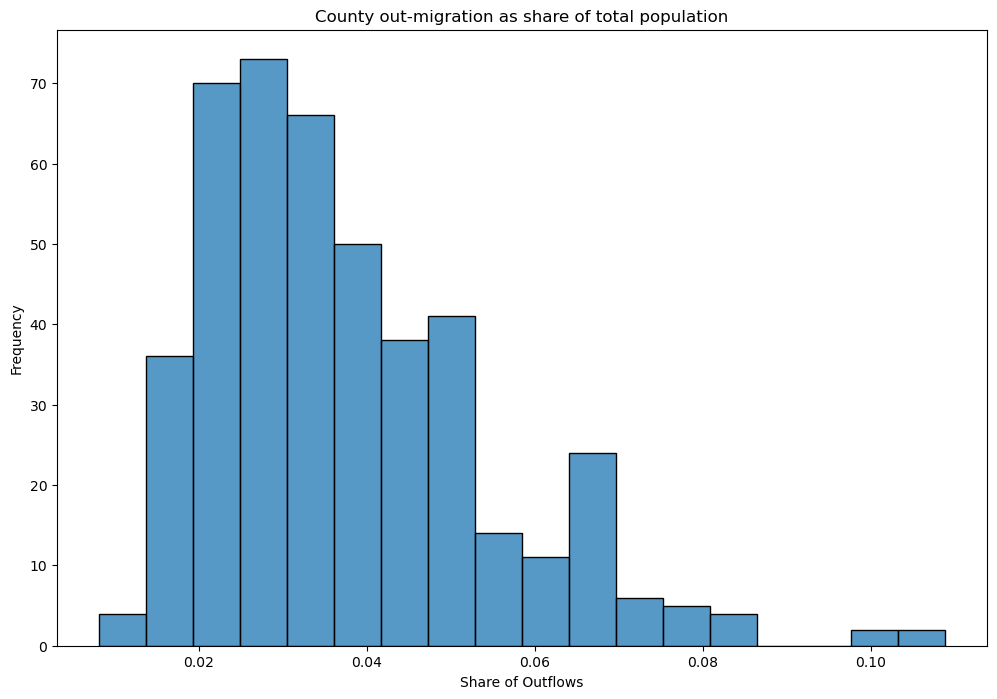

In [43]:
plt.figure(figsize=(12, 8))
sns.histplot(df_reduced['share_outflows'], kde=False)
plt.title('County out-migration as share of total population')
plt.xlabel('Share of Outflows')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

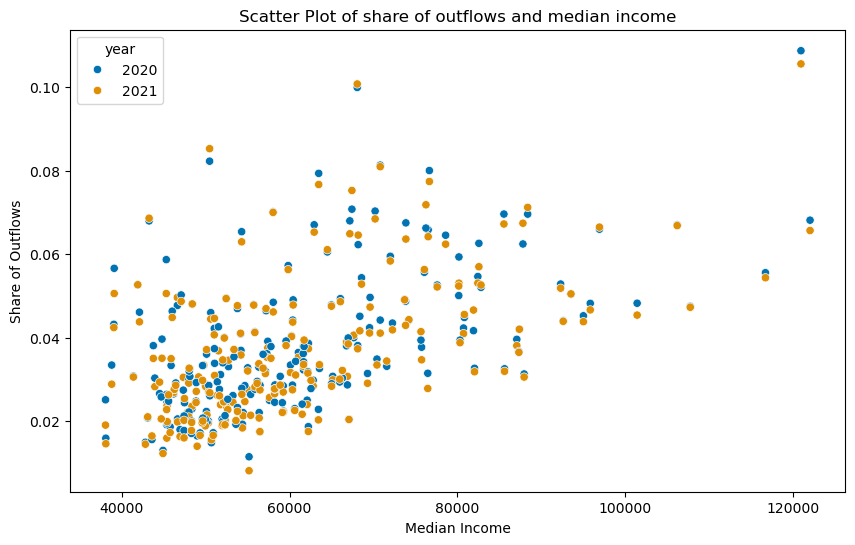

In [44]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='median_household_income', y='share_outflows', hue='year', palette='colorblind', data=df_reduced)
plt.title('Scatter Plot of share of outflows and median income')
plt.xlabel('Median Income')
plt.ylabel('Share of Outflows')
plt.show()

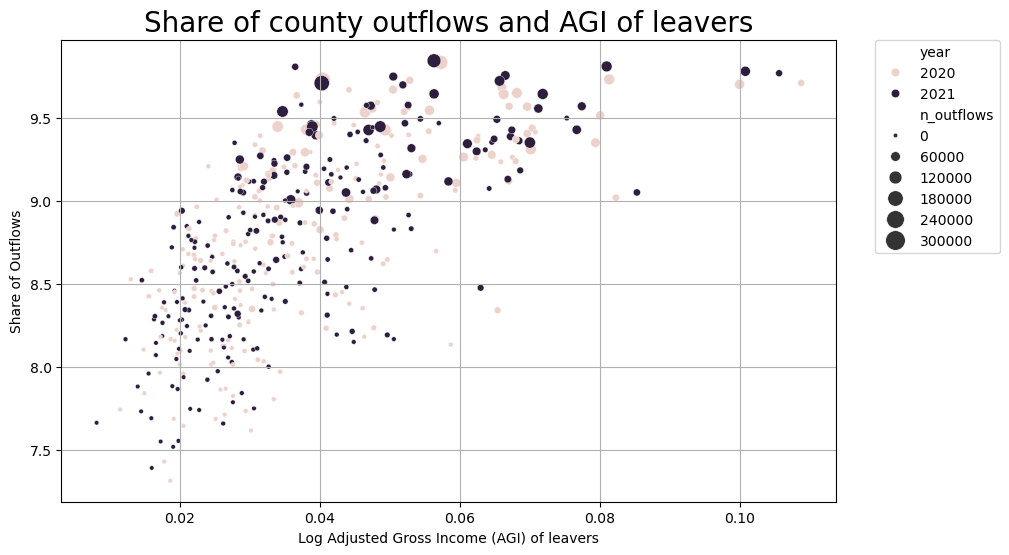

In [45]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_reduced, x='share_outflows', y='log_agi_leavers', hue='year',size='n_outflows', sizes=(10, 200))
plt.title('Share of county outflows and AGI of leavers', fontsize=20)
plt.xlabel('Log Adjusted Gross Income (AGI) of leavers')
plt.ylabel('Share of Outflows')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(True)
plt.show()


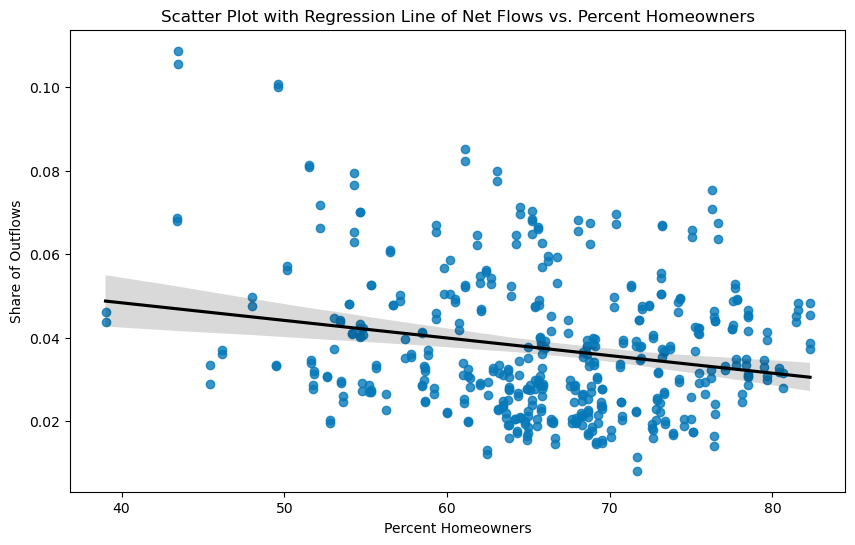

In [46]:
plt.figure(figsize=(10, 6))
sns.regplot(x='percent_homeowners', y='share_outflows', data=df_reduced, color='#0779B9', line_kws={"color": "black"})
plt.title('Scatter Plot with Regression Line of Net Flows vs. Percent Homeowners')
plt.xlabel('Percent Homeowners')
plt.ylabel('Share of Outflows')
plt.show()

<h2 style="color: black;"> Baseline Model </h2> 

_For our baseline model, we wanted to do both regression and LASSO so we know which associations are most important and so that the model is interpretable. The baseline model below uses the dataset downloaded from Kaggle and IRS's Migration Data, and ignores ACS for now._

In [47]:
#number of rows in the merged COVID and Net Migration data 
num_rows = len(df_reduced)
print("Number of rows:", num_rows)

#examining the level of missingness in the data
missing_percentage = df_reduced.isnull().sum() / len(df) * 100
print(missing_percentage)

Number of rows: 5741
fips_id                         0.000000
year                            0.000000
net_flows                       0.000000
n_outflows                      0.000000
cases                          92.231319
deaths                         92.231319
total_population               92.231319
population_density_per_sqmi    92.231319
high_school_graduation_rate    92.231319
median_household_income        92.231319
percent_homeowners             92.231319
percent_black                  92.231319
percent_asian                  92.231319
percent_hispanic               92.231319
percent_unemployed_CDC         92.231319
log_agi_leavers                 1.480578
share_flows                    92.231319
share_outflows                 92.231319
dtype: float64


In [48]:
#dropping the missing vars
df_base = df_reduced.dropna()
df_base = df_base.drop(['share_flows', 'net_flows','n_outflows'], axis=1)
num_rows = len(df_base)
print("Number of rows:", num_rows)

Number of rows: 446


In [49]:
df_base.columns

Index(['fips_id', 'year', 'cases', 'deaths', 'total_population',
       'population_density_per_sqmi', 'high_school_graduation_rate',
       'median_household_income', 'percent_homeowners', 'percent_black',
       'percent_asian', 'percent_hispanic', 'percent_unemployed_CDC',
       'log_agi_leavers', 'share_outflows'],
      dtype='object')

In [50]:
# Separate features and target variable
X = df_base.drop('share_outflows', axis=1)  # features
Y = df_base['share_outflows']  # target variable

# Split the dataset into the Training set and Test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [51]:
#Model 1: Baseline regression 

# Initialize the Linear Regression model
baseline_reg = LinearRegression()

# Fit the model to the training data
baseline_reg.fit(X_train, Y_train)

# Predict on the training set
Y_train_pred = baseline_reg.predict(X_train)

# Calculate the mean squared error on the train data
mse_train = mean_squared_error(Y_train, Y_train_pred)
print(f"Train MSE for Model 1: {mse_train}")

# Predict on the testing set
Y_test_pred = baseline_reg.predict(X_test)

# Calculate the mean squared error on the test data
mse_test = mean_squared_error(Y_test, Y_test_pred)
print(f"Test MSE for Model 1: {mse_test}")

Train MSE for Model 1: 9.456734192437597e-05
Test MSE for Model 1: 0.00011861868846117808


In [52]:
#Doing the same linear regression using only the data for 2021

df_2021 = df_base[df_base['year'] != 2020]

#number of rows in the data 
num_rows = len(df_2021)
print("Number of rows:", num_rows)

Number of rows: 223


In [53]:
df_2021.head(10)

,fips_id,year,cases,deaths,total_population,population_density_per_sqmi,high_school_graduation_rate,median_household_income,percent_homeowners,percent_black,percent_asian,percent_hispanic,percent_unemployed_CDC,log_agi_leavers,share_outflows
17,8001,2021,26129.0,315.0,479977.0,411.188748,77.259086,70199.0,65.210249,3.188517,4.370658,40.448905,6.1,9.360587,0.068478
21,17001,2021,4243.0,41.0,66949.0,78.284133,91.510770,55174.0,71.670330,3.763073,0.987959,1.660806,6.4,7.663676,0.008141
43,12001,2021,12395.0,97.0,256581.0,293.217548,84.217943,51026.0,54.812052,19.959549,6.260279,10.276119,7.0,8.509656,0.040704
74,26005,2021,3813.0,31.0,113666.0,137.737746,87.049301,62247.0,82.311628,1.314275,0.897492,7.425401,4.7,9.577979,0.037381
86,18003,2021,17060.0,301.0,365565.0,556.143777,91.815041,54473.0,68.257143,11.574766,4.376437,7.608079,7.0,8.341994,0.021307
92,39003,2021,4949.0,89.0,104664.0,260.034919,84.931507,50301.0,66.487407,12.357909,0.788015,3.163749,7.6,8.047421,0.019529
126,48005,2021,3571.0,98.0,87657.0,109.876235,92.400000,46653.0,66.400286,14.833739,1.077022,22.492307,8.3,7.554693,0.019827
148,8005,2021,23795.0,429.0,617668.0,774.088914,83.483871,76665.0,63.071490,10.514807,6.472056,19.488341,6.0,9.568346,0.077443
158,51013,2021,5994.0,157.0,226092.0,8698.596224,92.200000,120950.0,43.454677,9.038359,11.033972,15.790183,3.4,9.767180,0.105621
175,39007,2021,2283.0,54.0,99175.0,141.287677,87.985213,46950.0,70.067991,3.494610,0.511832,4.322362,8.1,8.285992,0.016335


In [54]:
# Separate features and target variable
X = df_2021.drop('share_outflows', axis=1)  # features
Y = df_2021['share_outflows']  # target variable

# Split the dataset into the Training set and Test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [55]:
#Model 2: Repeating the linear regression for only the 2021 data 

# Initialize the Linear Regression model
reg_2021 = LinearRegression()

# Fit the model to the training data
reg_2021.fit(X_train, Y_train)

# Predict on the training set
Y_train_pred_2021 = reg_2021.predict(X_train)

# Calculate the mean squared error on the train data
mse_train_2021 = mean_squared_error(Y_train, Y_train_pred_2021)
print(f"Train MSE for Model 2: {mse_train_2021}")

# Predict on the testing set
Y_test_pred_2021 = reg_2021.predict(X_test)

# Calculate the mean squared error on the test data
mse_test_2021 = mean_squared_error(Y_test, Y_test_pred_2021)
print(f"Test MSE for Model 2: {mse_test_2021}")

Train MSE for Model 2: 8.350293814195849e-05
Test MSE for Model 2: 0.00013552013628024423


In [56]:
# Model 3: LASSO regression
df['share_outflows'] = df['n_outflows']/df['total_population']
#dropping the rows with missingness 
df_lasso = df.dropna()

#number of rows in the data 
num_rows = len(df_2021)
print("Number of rows:", num_rows)

# Separate features and target variable
drop_cols = ['net_flows','share_outflows', 'agi_leavers', 'county_fips','n_inflows','n_outflows', 'county', 'state', 'date', 'stay_at_home_announced', 'stay_at_home_effective', 'CALL', 'station_name', 'precip_flag', 'date_stay_at_home_announced', 'date_stay_at_home_effective']

X = df_lasso.drop(drop_cols, axis=1)
Y = df_lasso['share_outflows'].dropna()

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

# Create and fit the LassoCV regression model
lasso_cv_model = LassoCV(cv=5, random_state=42)
lasso_cv_model.fit(X_train, Y_train)

# Optimal alpha value
optimal_alpha = lasso_cv_model.alpha_
print("Optimal Alpha Value:", optimal_alpha)

# Make predictions
train_pred_lasso_cv = lasso_cv_model.predict(X_train)
test_pred_lasso_cv = lasso_cv_model.predict(X_test)

# Calculate MSE
train_mse_lasso_cv = mean_squared_error(Y_train, train_pred_lasso_cv)
test_mse_lasso_cv = mean_squared_error(Y_test, test_pred_lasso_cv)

Number of rows: 223
Optimal Alpha Value: 6.24778638000902e-05


In [57]:
# Create and fit the Lasso regression model
lasso_model = Lasso(alpha=optimal_alpha)
lasso_model.fit(X_train, Y_train)

# Make predictions
train_pred_lasso = lasso_model.predict(X_train)
test_pred_lasso = lasso_model.predict(X_test)

# Calculate MSE
train_mse_lasso = mean_squared_error(Y_train, train_pred_lasso)
test_mse_lasso = mean_squared_error(Y_test, test_pred_lasso)

# Output the MSE values
print(f"Train MSE for Model 3: {train_mse_lasso}")
print(f"Test MSE for Model 3: {test_mse_lasso}")

Train MSE for Model 3: 1.7902420071480583e-05
Test MSE for Model 3: 4.250304873599504e-05


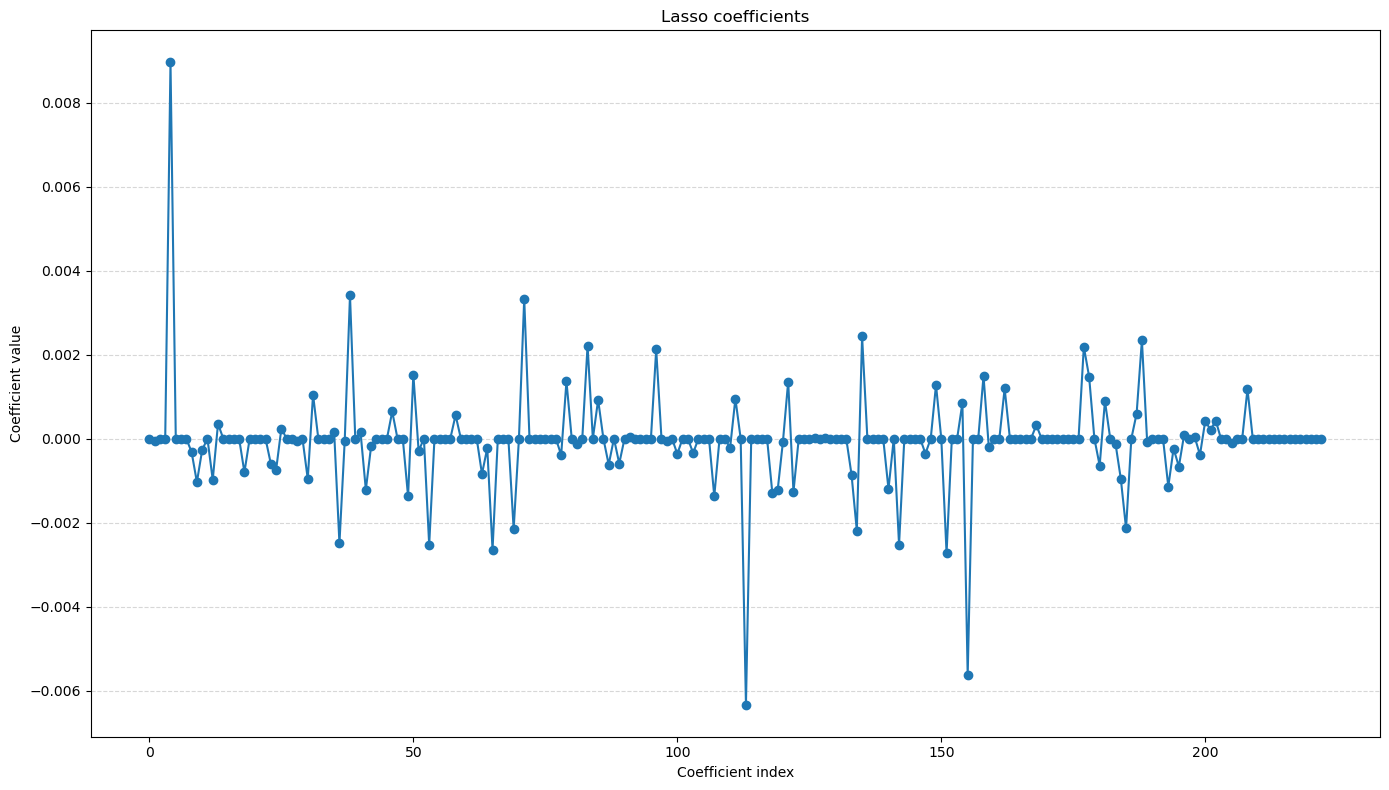

In [58]:
# plot for the Lasso coefficients with the best alpha

coefficients = lasso_model.coef_

plt.figure(figsize=(14, 8))
plt.plot(range(len(coefficients)), coefficients, marker='o')
plt.xlabel('Coefficient index')
plt.ylabel('Coefficient value')
plt.title('Lasso coefficients')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [59]:
predictor_list = X.columns.tolist()

coef_df = pd.DataFrame({
    'Predictor': predictor_list,
    'Coefficient': lasso_model.coef_.flatten()
})

In [60]:
# predictors that are most important from LASSO
non_zero_coef_df = coef_df[coef_df['Coefficient'] != 0]
non_zero_coef_df['Abs_Coefficient'] = non_zero_coef_df['Coefficient'].abs()

# sort the dataset based on absolute value of the coefficient
sorted_non_zero_coef_df = non_zero_coef_df.sort_values(by='Abs_Coefficient', ascending=False)

sorted_non_zero_coef_df = sorted_non_zero_coef_df.drop('Abs_Coefficient', axis=1)

In [61]:
sorted_non_zero_coef_df

,Predictor,Coefficient
4,log_agi_leavers,0.008955
113,percent_homeowners,-0.006332
155,percent_no_highschool_diploma,-0.005635
38,num_mental_health_providers,0.003409
71,percent_long_commute_drives_alone,0.003331
...,...,...
91,motor_vehicle_mortality_rate,0.000039
198,max_wind_speed,0.000037
128,percent_hispanic,0.000024
126,percent_native_hawaiian_other_pacific_islander,0.000021


In [99]:
len(sorted_non_zero_coef_df)

47

<h2 style="color: black;"> Interpretation </h2> 

In our analysis, we used three different models to understand out migration from a county. Our first model was a baseline regression model that incorporated all variables — a 'kitchen sink' approach. Now, many predictor values were similar for the years 2020 and 2021. We then narrowed our focus exclusively to data from 2021.  We applied two models to this subset: a standard regression and a LASSO regression. The LASSO model demonstrated a particularly strong performance, as seen by its very low training MSE, suggesting an excellent fit to the training data. Moreover, the model also shows signs of generalisation, as indicated by the low and only slightly higher test MSE compared to the training MSE. This close gap between the training and test MSEs can be attributed to the regularization effect in LASSO, which prevents overfitting.

The performance of the standard regression model using 2021 data lagged slightly behind the LASSO model. It showed a good fit to the training data, as reflected in its low training MSE. The test MSE was also low and closely aligned with the training MSE, signaling good generalization. However, both MSE values for this model were higher than those observed in the LASSO model. This slight underperformance could be due to the LASSO model's capacity for feature selection, which likely reduced the influence of less important or redundant features. In fact, out of 223 predictors, the LASSO model retained only about 21% of them, or only 47 predictors. These included significant variables like the percentage of homeowners in a county, adjusted growth income, and the percentage of the population that is 65 and over. The stronger performance of the LASSO model suggests that some level of regularization, which penalizes larger coefficients, was beneficial for this dataset, possibly due to certain features contributing to overfitting in the standard regression model.